# Performance Benchmarking with GuideLLM

This notebook will guide you through the process of running performance benchmarks on your deployed Large Language Model. We will use `guidellm`, a library designed to stress-test LLM endpoints to measure key performance indicators like throughput and latency under various loads.

Understanding these metrics is crucial for determining how well your model will perform in a real-world application and for making decisions about resource allocation.

# Step 0. Install GuideLLM & Import Scenario Tools

In [5]:
# Install GuideLLM
# TODO: Switch to PyPI after next release
%pip install -q git+https://github.com/neuralmagic/guidellm.git

# Install extra playbook requirements
%pip install -q ipywidgets matplotlib seaborn pandas


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
# FIXME: These imports should come from guidellm.benchmark in the future
from guidellm.benchmark.entrypoints import benchmark_with_scenario
from guidellm.benchmark.scenario import GenerativeTextScenario

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import JSON

In [7]:
sns.set_style("darkgrid")

## 2. Configuration

In this step, we'll set up all the configuration variables for our benchmark run.

**Action Required:**
You must replace the placeholder values below with the details for your specific model deployment.

1.  **`processor`**: The full Hugging Face model ID (e.g., `ibm-granite/granite-3.3-2B-instruct`). This is needed to download the correct tokenizer.
2.  **`model`**: The name you gave your deployment in OpenShift AI (e.g., `granite`).
3.  **`target`**: The **Inference endpoint** URL from your model's details page.
4.  **`api or token`**: Disabled for this exercise to reduce complexity

GuideLLM supports a variety of load generation modes and data sources. For this example we will use "concurrency" based load generation with a synthetically generated dataset. In concurrent mode GuideLLM will run a user specified number of concurrent requests. When any request completes, GuideLLM will spawn new requests to maintain the rate.

In [8]:
# FIXME: `data` should support dict input
scenario = GenerativeTextScenario(
    # The hostname of our model server
    target="https://granite-innovatech.apps.cluster-xwmgb.xwmgb.sandbox664.opentlc.com",
    
    # The name of the model we wish to test
    model="granite", # If unset defaults to first hosted model of server
    
    # The data processor of our model. GuideLLM will use this to 
    # For Text LLMs this is generally also refered to as the "Tokenizer".
    processor="ibm-granite/granite-3.3-2b-instruct", # If unset defaults to 'model'

    # Configure our load pattern and define a number of "rates". Rate refers to our primary testing variable
    # In the case of "concurrent" mode, rate is our request concuurnecy. Specifying multiple rates means we 
    # will run a benchmark for each rate.
    rate_type="concurrent",
    rate=[1, 2, 4, 16, 64],

    # For each rate: run a 30 second benchmark with no limit on the number of requests.
    max_seconds=30,
    max_requests=None,

    # Arguments to the synthetic dataset generator. Translates to "Generate a dataset were each request samples
    # from a normal distrubution of a number of input tokens with a mean of 256 and a stdev of 32. Ensure the 
    # model server always responds with 128 tokens."
    data="prompt_tokens=256,prompt_tokens_stdev=32,output_tokens=128",
)

# Display our scenario
JSON(scenario.model_dump())

<IPython.core.display.JSON object>

## Step 2. Run the Benchmark

In [9]:
# FIXME: output_path and output_extras should default to None
results, _ = await benchmark_with_scenario(scenario, output_path=None, output_extras=None)

╭─ Benchmarks ────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ [19:57… … concurre… (comple… Req:    0.3 req/s,    2.88s Lat,     1.0 Conc,      10 Comp,        1 Inc,       … │
│                              Tok:   44.4 gen/s,  131.4 tot/s,  49.5ms TTFT,   22.3ms ITL,   252 Prompt,      1… │
│ [19:58… … concurre… (comple… Req:    0.7 req/s,    3.02s Lat,     2.0 Conc,      18 Comp,        2 Inc,       … │
│                              Tok:   84.7 gen/s,  254.6 tot/s,  69.9ms TTFT,   23.2ms ITL,   257 Prompt,      1… │
│ [19:58… … concurre… (comple… Req:    1.3 req/s,    3.12s Lat,     4.0 Conc,      36 Comp,        4 Inc,       … │
│                              Tok:  163.6 gen/s,  494.2 tot/s,  97.9ms TTFT,   23.8ms ITL,   260 Prompt,      1… │
│ [19:59… … concurre… (comple… Req:    3.8 req/s,    3.68s Lat,    14.2 Conc,     114 Comp,       16 Inc,       … │
│                              Tok:  491.7 gen/s, 1492.1 tot/s, 232.3ms TTFT,   27.2ms ITL,   261 Prompt,      1… │
│ [19:59… … concurre… (compil… Req:    8.2 req/s,    5.29s Lat,     0.0 Conc,     256 Comp,       64 Inc,       … │
│                              Tok: 1304.2 gen/s, 3908.5 tot/s, 332.6ms TTFT,   48.7ms ITL,   256 Prompt,      1… │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
Generating... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ (4/5) [ 0:02:31 < 0:00:00 ]

Benchmarks Metadata:

Run id:c1bed026-09c3-4b48-88ae-48446cd43d91

Duration:153.8 seconds

Profile:type=concurrent, strategies=['concurrent', 'concurrent', 'concurrent', 'concurrent', 'concurrent'],    
    streams=[1, 2, 4, 16, 64]

Args:max_number=None, max_duration=30.0, warmup_number=None, warmup_duration=None, cooldown_number=None,       
    cooldown_duration=None

Worker:type_='generative_requests_worker' backend_type='openai_http'                                           
    backend_target='https://granite-innovatech.apps.cluster-xwmgb.xwmgb.sandbox664.opentlc.com'                    
    backend_model='granite' backend_info={'max_output_tokens': 16384, 'timeout': 300, 'http2': True,               
    'follow_redirects': True, 'authorization': False, 'organization': None, 'project': None,                       
    'text_completions_path': '/v1/completions', 'chat_completions_path': '/v1/chat/completions'}

Request Loader:type_='generative_request_loader'                                                               
    data='prompt_tokens=256,prompt_tokens_stdev=32,output_tokens=128' data_args=None                               
    processor='ibm-granite/granite-3.3-2b-instruct' processor_args=None

Extras:None

Benchmarks Info:

===================================================================================================================
==================================

Metadata                                      |||| Requests Made  ||| Prompt Tok/Req ||| Output Tok/Req ||| Prompt 
Tok Total  ||| Output Tok Total ||

    Benchmark| Start Time| End Time| Duration (s)|  Comp|  Inc|  Err|  Comp|   Inc| Err|  Comp|   Inc| Err|   Comp|
Inc|  Err|   Comp|   Inc|  Err

-------------|-----------|---------|-------------|------|-----|-----|------|------|----|------|------|----|-------|
-------|-----|-------|------|-----

 concurrent@1|   19:57:53| 19:58:23|         30.0|    10|    1|    0| 252.0| 263.0| 0.0| 128.0|  51.0| 0.0|   2520|
263|    0|   1280|    51|    0

 concurrent@2|   19:58:23| 19:58:53|         30.0|    18|    2|    0| 257.4| 241.0| 0.0| 128.0| 119.5| 0.0|   4634|
482|    0|   2304|   239|    0

 concurrent@4|   19:58:54| 19:59:24|         30.0|    36|    4|    0| 259.7| 279.2| 0.0| 128.0|  72.8| 0.0|   9350|
1117|    0|   4608|   291|    0

concurrent@16|   19:59:24| 19:59:54|         29.7|   114|   16|    0| 261.4| 263.1| 0.0| 128.0| 116.2| 0.0|  29802|
4209|    0|  14592|  1859|    0

concurrent@64|   19:59:56| 20:00:25|         28.8|   256|   64|    0| 255.9| 255.5| 0.0| 128.0|  14.9| 0.0|  65518|
16349|    0|  32768|   956|    0

===================================================================================================================
==================================

Benchmarks Stats:

===================================================================================================================
==================================

Metadata     | Request Stats         || Out Tok/sec| Tot Tok/sec| Req Latency (sec)  ||| TTFT (ms)         ||| ITL 
(ms)        ||| TPOT (ms)       ||

    Benchmark| Per Second| Concurrency|        mean|        mean|  mean|  median|   p99|  mean| median|   p99|     
mean| median|  p99| mean| median|  p99

-------------|-----------|------------|------------|------------|------|--------|------|------|-------|------|-----
|-------|-----|-----|-------|-----

 concurrent@1|       0.35|        1.00|        44.4|       131.4|  2.88|    2.88|  2.90|  49.5|   48.1|  58.0|     
22.3|   22.3| 22.5| 22.1|   22.1| 22.3

 concurrent@2|       0.66|        2.00|        84.7|       254.6|  3.02|    3.01|  3.04|  69.9|   73.1|  95.7|     
23.2|   23.2| 23.3| 23.0|   23.0| 23.1

 concurrent@4|       1.28|        3.99|       163.6|       494.2|  3.12|    3.13|  3.17|  97.9|  101.6| 169.4|     
23.8|   23.7| 24.2| 23.6|   23.6| 24.0

concurrent@16|       3.84|       14.16|       491.7|      1492.1|  3.68|    3.66|  3.93| 232.3|  250.2| 475.6|     
27.2|   27.3| 28.4| 27.0|   27.1| 28.1

concurrent@64|       9.02|       56.06|      1154.8|      3454.7|  6.21|    6.21|  6.50| 343.5|  374.7| 686.7|     
46.2|   46.1| 48.4| 45.9|   45.7| 48.0

===================================================================================================================
==================================

Benchmarking complete.

## Step 3. Analyze the Results

In [10]:
rows = []
for bench in results.benchmarks:
    rows.append({
        # Number of virtual concurrent users (our rate variable)
        "concurrency": bench.args.strategy.streams,

        # Number of requests by their status at the end of the test
        "requests_successful": bench.run_stats.requests_made.successful,
        "requests_incomplete": bench.run_stats.requests_made.incomplete,
        "requests_failed": bench.run_stats.requests_made.errored,

        # Latency metrics
        "ttft_median": bench.metrics.time_to_first_token_ms.successful.median,
        "ttft_p99": bench.metrics.time_to_first_token_ms.successful.percentiles.p99,
        "itl_median": bench.metrics.inter_token_latency_ms.successful.median,
        "itl_p99": bench.metrics.inter_token_latency_ms.successful.percentiles.p99,
        "e2e_median": bench.metrics.request_latency.successful.median,
        "e2e_p99": bench.metrics.request_latency.successful.percentiles.p99,

        # Throughput metrics
        "output_throughput": bench.metrics.output_tokens_per_second.successful.mean,
        "request_throughput": bench.metrics.requests_per_second.successful.mean,
    })

df = pd.DataFrame(rows)
df

,concurrency,requests_successful,requests_incomplete,requests_failed,ttft_median,ttft_p99,itl_median,itl_p99,e2e_median,e2e_p99,output_throughput,request_throughput
0,1,10,1,0,48.086166,57.989597,22.273839,22.451082,2.881026,2.899418,44.366559,0.346885
1,2,18,2,0,73.075771,95.659733,23.167379,23.325098,3.014724,3.037241,84.730022,0.662241
2,4,36,4,0,101.646900,169.411659,23.738088,24.184882,3.125530,3.167643,163.550212,1.278013
3,16,114,16,0,250.154734,475.625753,27.274858,28.351431,3.656928,3.930193,491.698453,3.841657
4,64,256,64,0,374.675274,686.650753,46.064294,48.408358,6.206300,6.495719,1154.777252,9.021973


Unless every request has the same number of input and output tokens a set of LLM requests is non-homogeneous. Thus request throughput can vary greatly in a set of requests. The atomic unit of work for a LLM is a token. Therefore when performance benchmarking LLMs, tokens per second is a more reliable measure of throughput than requests per second. However tokens per second can still depend on the number of input and output tokens so its still important to compare only results with the same distributions of input and output tokens in their dataset. For this example we ran all benchmarks with the same distributions so the results are comparable. 

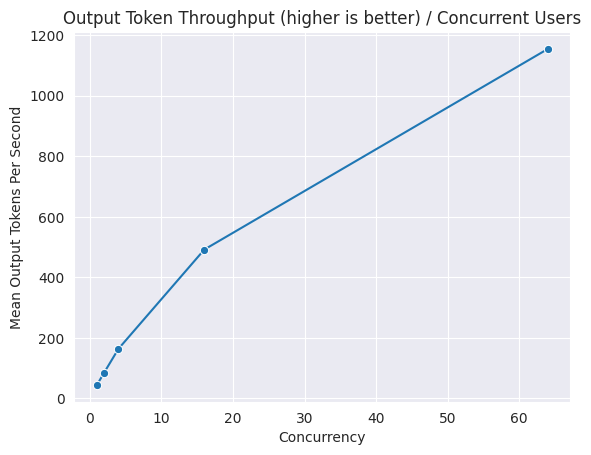

In [11]:
fig = sns.lineplot(df, x="concurrency", y="output_throughput", marker='o')
fig.set(
    title="Output Token Throughput (higher is better) / Concurrent Users",
    xlabel="Concurrency", 
    ylabel="Mean Output Tokens Per Second",
)
plt.show()

Most LLM serving runtimes support streaming back each token to the client as it is generated thus we can break up the total request latency into a few sub measurements of token latency. Time To First Token (TTFT) is the measure of time from when the client sends the request to when the server responds with the first token. Inter-Token Latency (ITL) is the delay between each token after the first token. Therefore request latency is roughly equal to TTFT + (ITL x number of output tokens).

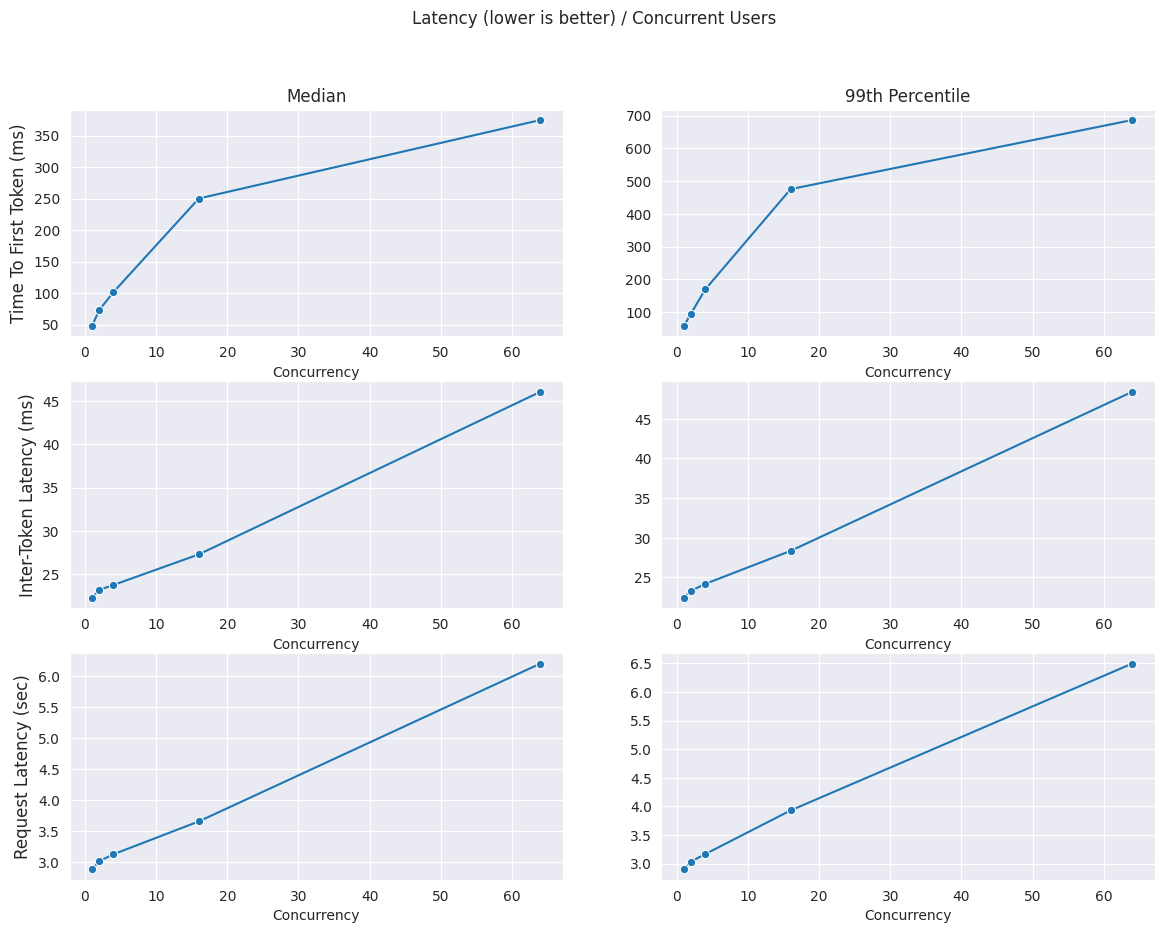

In [12]:
# Make a grid of latency metrics vs Concurrency
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle("Latency (lower is better) / Concurrent Users")
for ax, metric in zip(
    axes.flat, 
    ["ttft_median", "ttft_p99", "itl_median", "itl_p99", "e2e_median", "e2e_p99"],
):
    f = sns.lineplot(df, ax=ax, x="concurrency", y=metric, marker="o")
    f.set(xlabel="Concurrency", ylabel="")

for ax, col in zip(axes[0], ["Median", "99th Percentile"]):
    ax.set_title(col)

for ax, row in zip(
    axes[:,0], 
    [
        "Time To First Token (ms)",
        "Inter-Token Latency (ms)",
        "Request Latency (sec)",
    ]
):
    ax.set_ylabel(row, size='large')

fig.show()